# Interacting with Articulated Agents

In this tutorial we will show how to interact in Habitat via articulated agents. These are agents composed of different parts which can be articulated. Examples of these agents include different commercial robots (such as Spot, Fetch, Franka) or humanoids.
In this tutorial we will explore how to interact in Habitat with such agents. We will cover the following topics:

- How to initialize an agent
- Moving an agent around the scene
- Dynamic vs Kinematic Simulation
- Interacting with objects
- Interacting with Actions
- Multi-Agent simulation


In [10]:
import os
import copy
import habitat
import habitat_sim
import magnum as mn
import warnings
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
warnings.filterwarnings('ignore')
from habitat_sim.utils.settings import make_cfg
from matplotlib import pyplot as plt
from habitat_sim.utils import viz_utils as vut
from omegaconf import DictConfig, OmegaConf
import numpy as np
from habitat.articulated_agents.robots import FetchRobot
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import (
    ThirdRGBSensorConfig, 
    HeadRGBSensorConfig,
    HabitatSimSemanticSensorConfig,
    HeadDepthSensorConfig,
    HabitatSimDepthSensorConfig,
    HabitatSimFisheyeSemanticSensorConfig,
    HeadPanopticSensorConfig, 
    SimulatorConfig, 
    HabitatSimV0Config, 
    AgentConfig, 
    HumanoidJointActionConfig, 
    HumanoidPickActionConfig)
from habitat_sim.physics import JointMotorSettings, MotionType
from habitat.articulated_agent_controllers import (HumanoidRearrangeController, HumanoidSeqPoseController)
from habitat.utils.humanoid_utils import MotionConverterSMPLX
from habitat.config.default_structured_configs import TaskConfig, EnvironmentConfig, DatasetConfig, HabitatConfig
from habitat.config.default_structured_configs import ArmActionConfig, BaseVelocityActionConfig, OracleNavActionConfig
from habitat.core.env import Env
from habitat import Env, get_config
from habitat.core.registry import registry
from habitat.core.simulator import Sensor, SensorTypes
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from typing import Any, Dict, List, Union
import numpy as np
import git, os
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)


In [16]:
# Define the agent configuration
main_agent_config = AgentConfig()
urdf_path = os.path.join(data_path, "robots/hab_fetch/robots/hab_fetch.urdf")
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "FetchRobot"

# Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
# We will later talk about why we are giving the sensors these names
main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# We create a dictionary with names of agents and their corresponding agent configuration
agent_dict = {"main_agent": main_agent_config}


In [18]:
def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/hab3_bench_assets/episode_datasets/small_large.json.gz")
    
    hab_cfg = HabitatConfig()
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_habitat_sim(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

action_dict = {
    "oracle_magic_grasp_action": ArmActionConfig(type="MagicGraspAction"),
    "base_velocity_action": BaseVelocityActionConfig(),
    "oracle_coord_action": OracleNavActionConfig(type="OracleNavCoordinateAction", spawn_max_dist_to_obj=1.0)
}

env = init_habitat_sim(agent_dict, action_dict)

# Print available actions and their action space
print("Available Actions:")
for action_name, action_space in env.action_space.items():
    print(action_name, action_space)

# Reset environment and retrieve observations
obs = env.reset()
rgb_obs = obs["third_rgb"]
semantic_obs = obs["semantic_sensor"]

# Example of using base_velocity_action
observations = []
num_iter = 40
for _ in range(num_iter):
    params = env.action_space["base_velocity_action"].sample()
    action_dict = {
        "action": "base_velocity_action",
        "action_args": params
    }
    observations.append(env.step(action_dict))

# Visualize or process observations as needed
plt.imshow(rgb_obs)
plt.title("Third RGB Sensor")
plt.show()

plt.imshow(semantic_obs)
plt.title("Semantic Sensor")
plt.show()

# Example: Make a video from observations
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

AttributeError: 'HabitatSimV0Config' object has no attribute 'sensor_specifications'

In [3]:

def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # Enable Horizon Based Ambient Occlusion (HBAO) to approximate shadows.
    sim_cfg.habitat_sim_v0.enable_hbao = True
    
    sim_cfg.habitat_sim_v0.enable_physics = True

    
    # Set up an example scene
    sim_cfg.scene = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json")
    sim_cfg.scene_dataset = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json")
    sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')]

    
    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg

def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/hab3_bench_assets/episode_datasets/small_large.json.gz")
    
    
    hab_cfg = HabitatConfig()
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_habitat_sim(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

# def make_sim_cfg(scene_path):
#     # Habitat-Sim specific configuration
#     backend_cfg = habitat_sim.SimulatorConfiguration()
#     backend_cfg.scene_id = scene_path  # Set the scene path here
#     backend_cfg.scene_dataset_config_file = "/home/ramasamyn/hm3d-data/scene_datasets/hm3d/hm3d_annotated_basis.scene_dataset_config.json"

#     # Define sensor specifications (e.g., semantic sensor)
#     sem_cfg = habitat_sim.CameraSensorSpec()
#     sem_cfg.uuid = "semantic"
#     sem_cfg.sensor_type = habitat_sim.SensorType.SEMANTIC

#     # Agent configuration
#     agent_cfg = habitat_sim.agent.AgentConfiguration()
#     agent_cfg.sensor_specifications = [sem_cfg]

#     # Create Habitat-Sim configuration
#     sim_cfg = habitat_sim.Configuration(backend_cfg, [agent_cfg])

#     return sim_cfg

# def init_habitat_sim(scene_path):
#     sim_cfg = make_sim_cfg(scene_path)
#     sim = habitat_sim.Simulator(sim_cfg)
#     return sim

# # Example usage:
# scene_path = "/home/ramasamyn/hm3d-data/scene_datasets/hm3d/minival/00800-TEEsavR23oF/TEEsavR23oF.basis.glb"
# simulator = init_habitat_sim(scene_path)


2024-06-25 15:46:35,345 Initializing dataset RearrangeDataset-v0
2024-06-25 15:46:35,347 initializing sim RearrangeSim-v0
[15:46:35:414267]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
2024-06-25 15:46:35,543 Initializing task RearrangeEmptyTask-v0
[15:46:35:414320]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File../hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[15:46:35:414326]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `../hssd-hab_semantic_lexicon.json` nor constructed filename : `../info_semantic.json` exist on disk.
[15:46:35:414330]:[Error]:[Scene] SemanticScene.cpp(137)::load

Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.171.04
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
RearrangeSim(config=Configuration(sim_cfg=<habitat_

KeyboardInterrupt: 

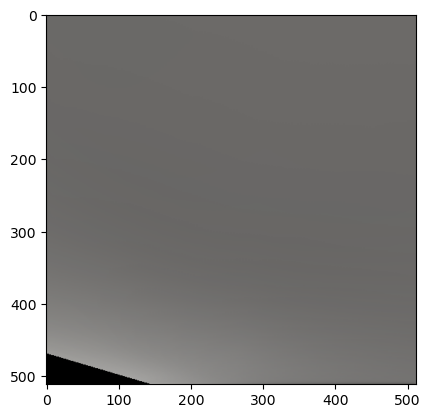

In [4]:
action_dict = {
    "oracle_magic_grasp_action": ArmActionConfig(type="MagicGraspAction"),
    "base_velocity_action": BaseVelocityActionConfig(),
    "oracle_coord_action": OracleNavActionConfig(type="OracleNavCoordinateAction", spawn_max_dist_to_obj=1.0)
}
env = init_habitat_sim(agent_dict, action_dict)

# The environment contains a pointer to an habitat simulator, which allows us to reproduce the steps we did before
print(env._sim)

# We can query the actions available, and their action space:
for action_name, action_space in env.action_space.items():
    print(action_name, action_space)

# Let's get an observation as before:
env.reset()
obs = env.step({"action": (), "action_args": {}})
plt.imshow(obs["third_rgb"])

# We can now call the defined actions
observations = []
num_iter = 40
for _ in range(num_iter):
    params = env.action_space["base_velocity_action"].sample()
    action_dict = {
        "action": "base_velocity_action",
        "action_args": params
    }
    observations.append(env.step(action_dict))
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

We can now call actions in the environment to update the agent. For this, we call the step function with the name of the action we want to execute and the parameters. We can also execute multiple actions at the same time. You can also implement novel actions.

One of the actions we defined was the OracleNavCoordAction, which uses a path planner to navigate to a given coordinate. We can use it to navigate to a specific object instance.

In [ ]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)

# print(sample)
observations = []
delta = 2.0

object_agent_vec = env.sim.articulated_agent.base_pos - object_trans
object_agent_vec.y = 0
dist_agent_object = object_agent_vec.length()
# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.articulated_agent.base_rot
prev_pos = env.sim.articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.articulated_agent.base_rot
    prev_pos = env.sim.articulated_agent.base_pos
    action_dict = {
        "action": ("oracle_coord_action"), 
        "action_args": {
              "oracle_nav_lookat_action": object_trans,
              "mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.articulated_agent.base_rot
    cur_pos = env.sim.articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)

# Wait
for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

002_master_chef_can_:0000 is in Vector(-7.16466, 0.98999, -5.21928)
Encoding the video: robot_tutorial_video.mp4 


# Multi-Agent Interaction
So far, we've been executing actions with a single agent. Habitat allows multi-agent execution, we will be looking here at how to do it 

In [ ]:

agent_1_config = AgentConfig()
urdf_path = "data/humanoids/humanoid_data/female_0/female_0.urdf"
agent_1_config.articulated_agent_urdf = urdf_path
agent_1_config.articulated_agent_type = "KinematicHumanoid"
agent_1_config.motion_data_path = "data/humanoids/humanoid_data/female_0/female_0_motion_data_smplx.pkl"

agent_2_config = AgentConfig()
urdf_path = "data/humanoids/humanoid_data/female_1/female_1.urdf"
agent_2_config.articulated_agent_urdf = urdf_path
agent_2_config.articulated_agent_type = "KinematicHumanoid"
agent_2_config.motion_data_path = "data/humanoids/humanoid_data/female_1/female_1_motion_data_smplx.pkl"

agent_3_config = AgentConfig()
urdf_path = "data/humanoids/humanoid_data/female_2/female_2.urdf"
agent_3_config.articulated_agent_urdf = urdf_path
agent_3_config.articulated_agent_type = "KinematicHumanoid"
agent_3_config.motion_data_path = "data/humanoids/humanoid_data/female_2/female_2_motion_data_smplx.pkl"

agent_4_config = AgentConfig()
urdf_path = "data/humanoids/humanoid_data/female_3/female_3.urdf"
agent_4_config.articulated_agent_urdf = urdf_path
agent_4_config.articulated_agent_type = "KinematicHumanoid"
agent_4_config.motion_data_path = "data/humanoids/humanoid_data/female_3/female_3_motion_data_smplx.pkl"

agent_5_config = AgentConfig()
urdf_path = "data/humanoids/humanoid_data/male_0/male_0.urdf"
agent_5_config.articulated_agent_urdf = urdf_path
agent_5_config.articulated_agent_type = "KinematicHumanoid"
agent_5_config.motion_data_path = "data/humanoids/humanoid_data/male_1/male_1_motion_data_smplx.pkl"

agent_6_config = AgentConfig()
urdf_path = "data/humanoids/humanoid_data/male_1/male_1.urdf"
agent_6_config.articulated_agent_urdf = urdf_path
agent_6_config.articulated_agent_type = "KinematicHumanoid"
agent_6_config.motion_data_path = "data/humanoids/humanoid_data/male_1/male_1_motion_data_smplx.pkl"

agent_7_config = AgentConfig()
urdf_path = "data/humanoids/humanoid_data/male_2/male_2.urdf"
agent_7_config.articulated_agent_urdf = urdf_path
agent_7_config.articulated_agent_type = "KinematicHumanoid"
agent_7_config.motion_data_path = "data/humanoids/humanoid_data/male_2/male_2_motion_data_smplx.pkl"

agent_8_config = AgentConfig()
urdf_path = "data/humanoids/humanoid_data/male_3/male_3.urdf"
agent_8_config.articulated_agent_urdf = urdf_path
agent_8_config.articulated_agent_type = "KinematicHumanoid"
agent_8_config.motion_data_path = "data/humanoids/humanoid_data/male_3/male_3_motion_data_smplx.pkl"

humanoid = [agent_1_config, agent_2_config, agent_3_config,agent_4_config, agent_5_config, agent_6_config, agent_7_config, agent_8_config]

for agent_config in humanoid:
    agent_config.sim_sensors = {
        "third_rgb": ThirdRGBSensorConfig(),
        "head_rgb": HeadRGBSensorConfig(),
    }


In [ ]:
second_agent_config = copy.deepcopy(main_agent_config)
second_agent_config.articulated_agent_urdf = os.path.join(data_path, "robots/hab_spot_arm/urdf/hab_spot_arm.urdf")
second_agent_config.articulated_agent_type = "SpotRobot"


third_agent_config = copy.deepcopy(main_agent_config)
third_agent_config.articulated_agent_urdf = os.path.join(data_path, "robots/hab_stretch/urdf/hab_stretch.urdf")
third_agent_config.articulated_agent_type = "StretchRobot"

agent_dict = {
    "agent_0": main_agent_config,
    "agent_1": agent_1_config,
    "agent_2": agent_2_config,
    "agent_3": agent_3_config,
    "agent_4": agent_4_config,
    "agent_5": agent_5_config,
    "agent_6": agent_6_config,
    "agent_7": agent_7_config,
    "agent_8": agent_8_config,
    "agent_9": second_agent_config,
    "agent_10": third_agent_config}


action_dict = {
    "oracle_magic_grasp_action": ArmActionConfig(type="MagicGraspAction"),
    "base_velocity_action": BaseVelocityActionConfig(),
    "oracle_coord_action": OracleNavActionConfig(type="OracleNavCoordinateAction", spawn_max_dist_to_obj=1.0)
}

multi_agent_action_dict = {}
for action_name, action_config in action_dict.items():
    for agent_id in range(10):
        multi_agent_action_dict[f"agent_{agent_id}_{action_name}"] = action_config 
env = init_habitat_sim(agent_dict, multi_agent_action_dict)

/home/ramasamyn/habitat-lab/robot_tutorial_video.mp4:1



SyntaxError: Invalid or unexpected token
    at internalCompileFunction (node:internal/vm:73:18)
    at wrapSafe (node:internal/modules/cjs/loader:1185:20)
    at Module._compile (node:internal/modules/cjs/loader:1227:27)
    at Module._extensions..js (node:internal/modules/cjs/loader:1326:10)
    at Module.load (node:internal/modules/cjs/loader:1126:32)
    at Module._load (node:internal/modules/cjs/loader:967:12)
    at c._load (node:electron/js2c/node_init:2:13672)
    at Function.executeUserEntryPoint [as runMain] (node:internal/modules/run_main:101:12)
    at node:internal/main/run_main_module:23:47

Node.js v18.18.2
2024-06-25 15:37:41,683 Initializing dataset RearrangeDataset-v0
2024-06-25 15:37:41,684 initializing sim RearrangeSim-v0
2024-06-25 15:37:41,928 Initializing task RearrangeEmptyTask-v0


In [ ]:
# agent_9_config = AgentConfig()
# urdf_path = "data/robots/hab_spot_arm/urdf/hab_spot_arm.urdf"
# agent_9_config.articulated_agent_urdf = urdf_path
# agent_9_config.articulated_agent_type = "SpotRobot"

# agent_10_config = AgentConfig()
# urdf_path = "data/robots/hab_stretch/urdf/hab_stretch.urdf"
# agent_10_config.articulated_agent_urdf = urdf_path
# agent_10_config.articulated_agent_type = "StretchRobot"

# agent_9_config = AgentConfig()
# urdf_path = "data/humanoids/humanoid_data/neutral_0/neutral_0.urdf"
# agent_9_config.articulated_agent_urdf = urdf_path
# agent_9_config.articulated_agent_type = "KinematicHumanoid"
# agent_9_config.motion_data_path = "data/humanoids/humanoid_data/neutral_0/neutral_0_motion_data_smplx.pkl"

# agent_10_config = AgentConfig()
# urdf_path = "data/humanoids/humanoid_data/neutral_1/neutral_1.urdf"
# agent_10_config.articulated_agent_urdf = urdf_path
# agent_10_config.articulated_agent_type = "KinematicHumanoid"
# agent_10_config.motion_data_path = "data/humanoids/humanoid_data/neutral_1/neutral_1_motion_data_smplx.pkl"

# agent_11_config = AgentConfig()
# urdf_path = "data/humanoids/humanoid_data/neutral_2/neutral_2.urdf"
# agent_11_config.articulated_agent_urdf = urdf_path
# agent_11_config.articulated_agent_type = "KinematicHumanoid"
# agent_11_config.motion_data_path = "data/humanoids/humanoid_data/neutral_2/neutral_2_motion_data_smplx.pkl"

# agent_12_config = AgentConfig()
# urdf_path = "data/humanoids/humanoid_data/neutral_3/neutral_3.urdf"
# agent_12_config.articulated_agent_urdf = urdf_path
# agent_12_config.articulated_agent_type = "KinematicHumanoid"
# agent_12_config.motion_data_path = "data/humanoids/humanoid_data/neutral_3/neutral_3_motion_data_smplx.pkl"

# We create a dictionary with names of agents and their corresponding agent configuration

# action_dict = {
#     "agent_1_humanoid_joint_action": HumanoidJointActionConfig(),
#     "agent_2_humanoid_joint_action": HumanoidJointActionConfig(),
#     "agent_3_humanoid_joint_action": HumanoidJointActionConfig(),
#     "agent_4_humanoid_joint_action": HumanoidJointActionConfig(),
#     "agent_5_humanoid_joint_action": HumanoidJointActionConfig(),
#     "agent_6_humanoid_joint_action": HumanoidJointActionConfig(),
#     "agent_7_humanoid_joint_action": HumanoidJointActionConfig(),
#     "agent_8_humanoid_joint_action": HumanoidJointActionConfig()}



#### The environment takes care about adding prefixes to observations, so that you can query the observation of each of the agents

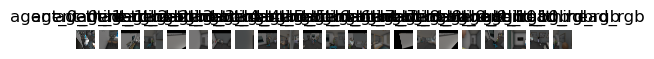

In [ ]:
observations = env.reset()
_, ax = plt.subplots(1,len(observations.keys()))

for ind, name in enumerate(observations.keys()):
    ax[ind].imshow(observations[name])
    ax[ind].set_axis_off()
    ax[ind].set_title(name)

# To query the agent positions, we need to use `agents_mgr[agent_index]` articulated_agent
env.sim.agents_mgr[0].articulated_agent

As before, we can call actions on the agents, prepending the agent_name before the action

In [ ]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
observations = []

# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
    action_dict = {
        "action": ("agent_0_oracle_coord_action", "agent_1_oracle_coord_action"), 
        "action_args": {
              "agent_0_oracle_nav_lookat_action": object_trans,
              "agent_0_mode": 1,
              "agent_1_oracle_nav_lookat_action": object_trans,
              "agent_1_mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    cur_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
    print(agent_rot, agent_displ)
vut.make_video(
    observations,
    "agent_1_third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

0.08333325386047363 0.0
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
2.384185791015625e-07 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
2.384185791015625e-07 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333323150873184
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.0 0.08333335071802139
0.08333325386047363 0.0
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 0.08333341032266617
0.0 

/home/ramasamyn/habitat-lab/robot_tutorial_video.mp4:1



SyntaxError: Invalid or unexpected token
    at internalCompileFunction (node:internal/vm:73:18)
    at wrapSafe (node:internal/modules/cjs/loader:1185:20)
    at Module._compile (node:internal/modules/cjs/loader:1227:27)
    at Module._extensions..js (node:internal/modules/cjs/loader:1326:10)
    at Module.load (node:internal/modules/cjs/loader:1126:32)
    at Module._load (node:internal/modules/cjs/loader:967:12)
    at c._load (node:electron/js2c/node_init:2:13672)
    at Function.executeUserEntryPoint [as runMain] (node:internal/modules/run_main:101:12)
    at node:internal/main/run_main_module:23:47

Node.js v18.18.2
